In [2]:
# import modules
import importlib
from pypet import Environment, Parameter, cartesian_product, progressbar, Trajectory
import numpy as np
import csv
import os
import copy
import pickle
import logging
from datetime import date
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import scipy
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
from fitnessinference import simulation as simu
from fitnessinference import analysis as ana
import sys
from Bio.Seq import Seq
from Bio import SeqIO

In [ ]:
# run this to reload a module after editing it 
# (instead of restarting the whole notebook kernel):
importlib.reload(ana)

In [22]:
# # test fitness coefficients used in simulation 
## I find that the values, especially J_min and J_max that I replace the max and min of the short sequences with
# is not the max/min of the longest sequence!!!! NEEDS TO BE CORRECTED IN FUTURE SIMULATIONS!!!

filepath = os.path.join(os.getcwd(), 'p24-B-S0.90-Ising-reduced-out-learn.j')
with open(filepath) as f:
    reader = csv.reader(f, delimiter = '\t')
    param_list = list(reader)
# calculate sequence length from the coeff data
seq_length = int((np.sqrt(1 + 8 * len(param_list)) - 1) / 2)
print(seq_length)
# separate h and J list
h_list = [[float(param_list[i][j]) for j in range(len(param_list[i]))]
         for i in range(seq_length)]
J_list = [[float(param_list[i][j]) for j in range(len(param_list[i]))]
          for i in range(seq_length, len(param_list))]
# calculate matrix from J_list
k=0
J_mat=[[[] for j in range(seq_length)] for i in range(seq_length)]
for i in range(seq_length):
    for j in range(i):
        J_mat[i][j]=J_list[k]
        J_mat[j][i]=J_list[k]
        k+=1
        
N_state = 2
N_site = 105
# reduce J and h lists to sequence of length N_site
J_list_red = []
for i in range(N_site):
    for j in range(i):
        J_list_red.append(J_mat[i][j])
h_list_red = h_list[:N_site]
# sample from h and J parameters to get coefficient lists for only N_state states at each site
J_list_final = np.array([np.random.choice(J_list_red[i], size=(N_state-1, N_state-1))
                        for i in range(len(J_list_red))])
h_list_final = np.array([np.random.choice(h_list_red[i], size=N_state-1)
                        for i in range(len(h_list_red))])
        
print(np.min(J_list_final), np.max(J_list_final))
print(np.min(h_list_final), np.max(h_list_final))
print(len(J_list_final))

105
-1.754271 2.921498
-8.814354 -0.9674582
5460


In [ ]:
# # simulation params, which should be stored
# # at initialization of simulation in the simulation folder


# simu_dict = {}

# simu_name = '2021Apr07'

# result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
#                     'InfluenzaFitnessInference')
# result_directory = os.path.normpath(result_directory)
# simu_code_file = 'simulation.py'
# simu_code_filepath = os.path.join(result_directory, 'code', 'notebooks', 'fitnessinference', simu_code_file)

# simu_comment = 'simulation with varying population size'

# varied_simu_params = ['N_pop']

# simu_param_dict = dict(N_pop = 10**2,
#                        N_site = 20,
#                        N_state = 2,
#                        mu = 10**(-4),
#                        sigma_h = 1,
#                        D0 = 5,
#                        h_0 = -7,
#                        J_0 = 0,
#                        hJ_coeffs = 'p24',
#                        seed = 123456,
#                        N_simu = 200 
#                       )

# exp_dict = {'N_pop' : [10, 100, 10**3, 10**4, 10**5, 10**6]}

# for key, val in exp_dict.items():
#     num_runs = len(val)
#     break
# run_list = np.arange(num_runs).tolist()

# # for later simus, simply call run_name = 'run_' + str(i) for run number i
# run_names = {}
# for i in range(len(exp_dict['N_pop'])):
#     if exp_dict['N_pop'][i] == 10:
#         params = 'N_pop_10N_site_20N_state_2mu_1e-04sigma_h_1D0_5h_0_-7J_0_0seed_123456N_simu_2e+02'
#     else:
#         params = ('N_pop_%.eN_site_%.iN_state_%.imu_%.esigma_h_%.iD0_%.ih_0_%.iJ_0_%.iseed_%.iN_simu_%.e' % (exp_dict['N_pop'][i], 
#                                                                                                                  simu_param_dict['N_site'], 
#                                                                                                                  simu_param_dict['N_state'], 
#                                                                                                                  simu_param_dict['mu'], 
#                                                                                                                  simu_param_dict['sigma_h'], 
#                                                                                                                  simu_param_dict['D0'], 
#                                                                                                                  simu_param_dict['h_0'], 
#                                                                                                                  simu_param_dict['J_0'], 
#                                                                                                                  simu_param_dict['seed'], 
#                                                                                                                  simu_param_dict['N_simu']))
#     run_name = 'running_' + params
#     run_names[i] = run_name

# # store the various params, which describe the simu, in a dictionary
# simu_dict['simu_name'] = simu_name
# simu_dict['simu_code_filepath'] = simu_code_filepath
# simu_dict['simu_comment'] = simu_comment
# simu_dict['varied_simu_params'] = varied_simu_params
# simu_dict['simu_param_dict'] = simu_param_dict
# simu_dict['exp_dict'] = exp_dict
# simu_dict['run_list'] = run_list
# simu_dict['run_names'] = run_names

# simu_info_filename = 'simu_info.data'
# temp_folder = os.path.join(result_directory, 'results', 'simulations', simu_name + '_temp')
# simu_info_filepath = os.path.join(temp_folder, simu_info_filename)
# with open(simu_info_filepath, 'wb') as f:
#     pickle.dump(simu_dict, f)

In [ ]:
# # run analyses and save results for individual anas plus collected params/data

# # set sampling and  default inference parameters
# simu_name = '2021Apr16'

# # initialize dictionary for saving collected analysis params and results
# ana_dict={}

# # folder and file paths (save with date of analysis)
# today = date.today()
# strdate_today = today.strftime("%Y%b%d")
# analysis_name = "analysis_" + strdate_today
# result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
#                     'InfluenzaFitnessInference')
# result_directory = os.path.normpath(result_directory)
# temp_folder = os.path.join(result_directory, 'results', 'simulations', simu_name + '_temp')
# analysis_info_path = os.path.join(temp_folder, analysis_name + '.data')
# while os.path.exists(analysis_info_path):
#     # for each new analysis on the same day, add 'i' to file_name
#     # to not overwrite files
#     analysis_name = analysis_name + 'i'
#     analysis_info_path = os.path.join(temp_folder, analysis_name + '.data')    

# ana_code_file = 'flu_sequence_analysis.ipynb'
# ana_code_filepath = os.path.join(os.getcwd(), ana_code_file)

# ana_param_dict ={'seed': 20390, 
#                'B': 10**3, 
#                'inf_start': 100, 
#                'inf_end': 200, 
#                'lambda_h': 10**(-4), 
#                'lambda_J': 1, 
#                'lambda_f': 10**(-4)
#           }

# varied_ana_params = ['B', 'inf_end']

# # lists of equal lengths to define param combos
# exp_ana_dict = {'B': [10, 100, 10**3, 10**4, 10**5], 'inf_end': [110, 120, 150, 200]}
# exp_ana_dict = cartesian_product(exp_ana_dict)

# ana_comment = 'analysis with varying'
# for p in varied_ana_params:
#     ana_comment += ' ' + p

# # load simulation info file
# simu_info_filename = 'simu_info.data'
# simu_info_filepath = os.path.join(temp_folder, simu_info_filename)
# with open(simu_info_filepath, 'rb') as f:
#     simu_dict = pickle.load(f)

# # dictionary with params varied during simulation
# exp_dict = simu_dict['exp_dict']
# # list of run numbers
# run_list = simu_dict['run_list']
# # list of file names for each run (without extension)
# run_names = simu_dict['run_names']
    
# # calculate number of analyses per simulation
# # and create ana_list
# for key, val in exp_ana_dict.items():
#     num_anas = len(val)
#     break
# ana_list = np.arange(num_anas).tolist()

# summary_stats_all = {
#         'r_h': [],
#         'pr_h': [],
#         'SE_r_h': [],
#         'r_J': [],
#         'pr_J': [],
#         'SE_r_J': [],
#         'r_hJ': [],
#         'pr_hJ': [],
#         'SE_r_hJ': [],
#         'rho_h': [],
#         'prho_h': [],
#         'SE_rho_h': [],
#         'rho_J': [],
#         'prho_J': [],
#         'SE_rho_J': [],
#         'rho_hJ': [],
#         'prho_hJ': [],
#         'SE_rho_hJ': [],
#         'f_host_std': [],
#         'f_int_std': [],
#         'f_tot_std': [],
#         'mean_string': [],
#         'SE_string': []
#     } 

# # do analyses and create analysis names/files
# ana_names = {}
# k = 0
# for ananum in range(len(ana_list)):
#     # set the name for this set of ana params
#     ana_id = analysis_name + '_' + str(ananum)
#     # set the analysis parameter values
#     # to the current set of values
#     for p in varied_ana_params:
#         ana_param_dict[p] = exp_ana_dict[p][ananum]
#     for run in run_list:
#         # store name of this analysis of this run
#         run_name_short = 'run_' + str(run)
#         ana_name = ana_id + run_name_short
#         ana_names[k] = ana_name
        
#         # inference/analysis for this combo of ana and run
#         single_simu_filename = run_names[run] + '.data'
        
#         # run analysis of single run
#         analysis_results = ana.single_simu_analysis(single_simu_filename, simu_name, run, ana_param_dict)
        
#         single_ana_filename = ana_name + '.data'
#         single_ana_filepath = os.path.join(temp_folder, single_ana_filename)
#         with open(single_ana_filepath, 'wb') as f:
#             pickle.dump(analysis_results, f)
            
#         summary_stats = analysis_results['summary_stats']
#         # append to lists of summary stats
#         for key, val in summary_stats_all.items():
#             val.append(summary_stats[key])
#             summary_stats_all[key] = val
        
#         # update number of this single analysis
#         k += 1
# # total number of analyses
# num_ana_tot = k    

# ana_dict['analysis_name'] = analysis_name
# ana_dict['ana_code_filepath'] = ana_code_filepath
# ana_dict['ana_param_dict'] = ana_param_dict
# ana_dict['varied_ana_params'] = varied_ana_params
# ana_dict['exp_ana_dict'] = exp_ana_dict
# ana_dict['ana_comment'] = ana_comment
# ana_dict['simu_info_filepath'] = simu_info_filepath
# ana_dict['ana_list'] = ana_list
# ana_dict['ana_names'] = ana_names
# ana_dict['summary_stats_all'] = summary_stats_all
# ana_dict['num_ana_tot'] = num_ana_tot

# with open(analysis_info_path, 'wb') as f:
#     pickle.dump(ana_dict, f)

# # exp_simuinf_dict = copy.deepcopy(exp_inf_dict)
# # exp_simuinf_dict['x'] = [1, 2]
# # exp_simuinf_dict = cartesian_product(exp_simuinf_dict)
# # print(exp_inf_dict)
# # print(exp_simuinf_dict)

{'N_site': [5, 10, 20, 30, 50, 100]}
{'B': [10, 10, 10, 10, 100, 100, 100, 100, 1000, 1000, 1000, 1000, 10000, 10000, 10000, 10000, 100000, 100000, 100000, 100000], 'inf_end': [110, 120, 150, 200, 110, 120, 150, 200, 110, 120, 150, 200, 110, 120, 150, 200, 110, 120, 150, 200]}


KeyError: 'classification_dict'

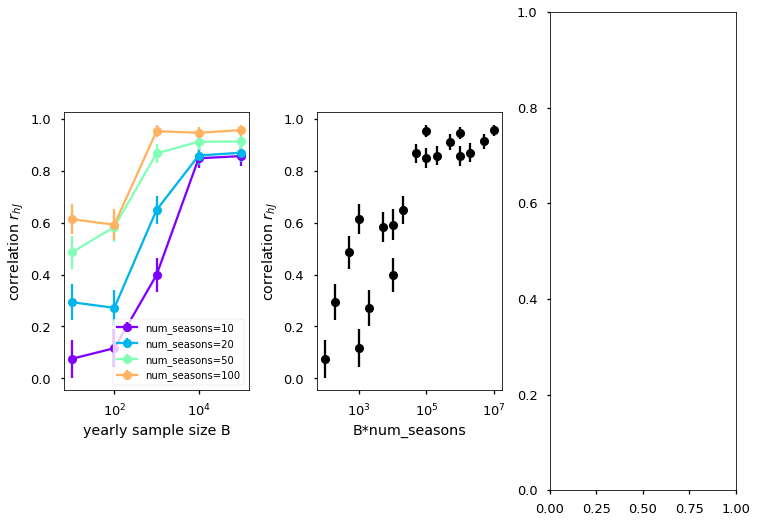

In [26]:
# load analysis results and make plots for num_seasons, B, L
# set legend font size
plt.rc('legend', fontsize=10)

simu_name = '2021Apr16'
# analysis_filename = 'analysis_2021Apr17.data'
analysis_filename = 'analysis_2021May04.data'

result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
                    'InfluenzaFitnessInference')
result_directory = os.path.normpath(result_directory)
temp_folder = os.path.join(result_directory, 'results', 'simulations', simu_name + '_temp')

analysis_filepath = os.path.join(temp_folder, analysis_filename)
with open(analysis_filepath, 'rb') as f:
    ana_dict = pickle.load(f)
simu_info_filepath = ana_dict['simu_info_filepath']
with open(simu_info_filepath, 'rb') as f:
    simu_dict = pickle.load(f)
    
summary_stats_all = ana_dict['summary_stats_all']
ana_param_dict = ana_dict['ana_param_dict']
varied_ana_params = ana_dict['varied_ana_params']
varied_simu_params = simu_dict['varied_simu_params']
ana_list = ana_dict['ana_list']
run_list = simu_dict['run_list']
exp_dict = simu_dict['exp_dict']
exp_ana_dict = ana_dict['exp_ana_dict']
print(exp_dict)
print(exp_ana_dict)

# plot names
file_ext_length = len('.data')
plot_file_path = analysis_filepath[:-file_ext_length] + '_plot'

#####################################################
## plot with varying num_seasons and B
################################################
# choose summary stat to plot as function of various parameters
stat_name1 = 'r_hJ'
stat = summary_stats_all[stat_name1]
SE_stat = summary_stats_all['SE_' + stat_name1]

# stat_name2 = 'AUC_ROC'
# stat = ana_dict['classification_dict'][stat_name2]
# SE_stat = [0 for i in range(len(stat))]

# plot name and initialization

this_plot_filepath = plot_file_path + '_numSamples' + '.png'

fig, ((ax1, ax1b, ax2)) = plt.subplots(1,3, constrained_layout=True)

legend_pos = (0.5, -0.3)

#######################
# plot in first panel: r_hJ for L=20 as function of B and num_seasons

# # transform list into array with shape (num_ana, num_run)
# stat_arr = np.reshape(np.array(stat), (len(ana_list), len(run_list)))
# SE_stat_arr = np.reshape(np.array(SE_stat), (len(ana_list), len(run_list)))

# or make custom array, if there are more than one run or ana params
custom_arr = 'yes'

if custom_arr == 'yes':
    ana_par1 = 'B'
    ana_par2 = 'inf_end'
    simu_par_fixed = 'N_site' # fixed simu parameter
    simu_par_fixed_val = 20
    ana_par1_list = []
    ana_par2_list = []
    stat_arr = []
    SE_stat_arr = []
    k = 0
    ana_par1_val = exp_ana_dict[ana_par1][0]
    ana_par1_list.append(ana_par1_val)
    stat_list = []
    SE_stat_list = []
    for ananum in range(len(exp_ana_dict[ana_par1])):
        if ana_par1_val==exp_ana_dict[ana_par1][0]:
            ana_par2_list.append(exp_ana_dict[ana_par2][ananum])
        for runnum in range(len(exp_dict[simu_par_fixed])):
            if exp_ana_dict[ana_par1][ananum]==ana_par1_val:
                if exp_dict[simu_par_fixed][runnum]==simu_par_fixed_val:
                    stat_list.append(stat[k])
                    SE_stat_list.append(SE_stat[k])
            else:
                ana_par1_val = exp_ana_dict[ana_par1][ananum]
                ana_par1_list.append(ana_par1_val)
                stat_arr.append(stat_list)
                SE_stat_arr.append(SE_stat_list)
                stat_list = []
                SE_stat_list = []
                if exp_dict[simu_par_fixed][runnum]==simu_par_fixed_val:
                    stat_list.append(stat[k])
                    SE_stat_list.append(SE_stat[k])
            k += 1
    stat_arr.append(stat_list)
    SE_stat_arr.append(SE_stat_list)
    
    stat_arr = np.array(stat_arr)
    SE_stat_arr = np.array(SE_stat_arr)
    
num_colors = stat_arr.shape[1]
cm = plt.get_cmap('rainbow')
colorlist = [cm(1.*i/num_colors) for i in range(num_colors)]
    
# analysis parameter to vary on x-axis 
x_ax_param = 'B'
# simu param to vary as line color
line_param = 'inf_end'
test_param_list = ana_par1_list
test_param_lines = ana_par2_list
for i in range(stat_arr.shape[1]):
    # plot linear correlation against varied simu param for a specific set
    # of analysis params
    ax1.errorbar(test_param_list, stat_arr[:, i], SE_stat_arr[:, i], 
                 marker='o',linestyle='-',zorder=1, color=colorlist[i],
                 label='num_seasons' + '=%.i' % (test_param_lines[i]-100))
# ax1.legend(bbox_to_anchor=legend_pos)
ax1.legend()
ax1.set_xlabel('yearly sample size ' + x_ax_param)
ax1.set_ylabel('correlation $r_{hJ}$')
ax1.set_xscale('log')
ax1.set_aspect(1.5/ax1.get_data_ratio())
##################################
# plot in panel 1 b: plot of r_hJ for L=20 as function of b*num_seasons

inf_start = ana_dict['ana_param_dict']['inf_start']
# transform list into array with shape (num_ana, num_run)
stat_arr = np.reshape(np.array(stat), (len(ana_list), len(run_list)))
SE_stat_arr = np.reshape(np.array(SE_stat), (len(ana_list), len(run_list)))
ana_par_list = []
ana_par1 = 'B'
ana_par2 = 'inf_end'
for ananum in range(len(exp_ana_dict[ana_par1])):
    ana_par_list.append(exp_ana_dict[ana_par1][ananum]*(exp_ana_dict[ana_par2][ananum]-inf_start))
# stat_arr = np.nan_to_num(stat_arr)
SE_stat_arr = np.nan_to_num(SE_stat_arr)
    
num_colors = stat_arr.shape[1]
cm = plt.get_cmap('rainbow')
colorlist = [cm(1.*i/num_colors) for i in range(num_colors)]

  
# analysis parameter to vary on x-axis 
x_ax_param = 'B*num_seasons'
# simu param to vary as line color
line_param = 'N_site'
test_param_list = ana_par_list
test_param_lines = exp_dict[line_param]
# for i in range(stat_arr.shape[1]):
i=2
# plot linear correlation against varied simu param for a specific set
# of analysis params
ax1b.errorbar(test_param_list[:], stat_arr[:, i], SE_stat_arr[:, i], 
             marker='o',linestyle='none',zorder=1, color='black',
             label='L' + '=%.i' % (test_param_lines[i]))
# ax1b.legend(bbox_to_anchor=legend_pos)
ax1b.set_xlabel(x_ax_param)
ax1b.set_ylabel('correlation $r_{hJ}$')
ax1b.set_xscale('log')
ax1b.set_aspect(1.5/ax1b.get_data_ratio())

########################################
################
# # # calculate and save classification performance measures, if not saved already
# hJ_threshold = -10

# ana_names = ana_dict['ana_names'] 

# # dictionary to save classification results
# classification_dict = {'AUC_prec_recall': [],
#                       'AUC_ROC': [],
#                       'hJ_threshold': hJ_threshold,
#                       'class_imbalance': []}

# simu_param_dict = simu_dict['simu_param_dict']

# # count the single analyses
# k=0
# for ananum in ana_list:
#     for runnum in run_list:
#         # update parameter values that were varied
#         for param_name, params in exp_dict.items():
#             simu_param_dict[param_name] = params[runnum]
#         N_site = simu_param_dict['N_site']
#         N_state = simu_param_dict['N_state']
#         h_0 = simu_param_dict['h_0']
#         J_0 = simu_param_dict['J_0']
#         hJ_coeffs = simu_param_dict['hJ_coeffs']
#         if hJ_coeffs=='constant':
#             h_model, J_model = simu.fitness_coeff_constant(N_site, N_state, h_0, J_0)
#         elif hJ_coeffs=='p24':
#             h_model, J_model = simu.fitness_coeff_p24(N_site, N_state)
#         h_model_list, J_model_list, hJ_model_list = ana.hJ_model_lists(h_model, J_model)
#         # real classification of each pair according to known hJs
#         hJ_deleterious = np.int_(hJ_model_list<hJ_threshold)
#         # class imbalance: number in deleterious class/total number of pairs
#         positive_rate = sum(hJ_deleterious)/len(hJ_deleterious)
# #         print('class imbalance: ', positive_rate)
    
#         # load single-analysis file
#         ana_name = ana_names[k]
#         ana_file_path = os.path.join(temp_folder, ana_name + '.data')
#         with open(ana_file_path, 'rb') as f:
#             analysis_results = pickle.load(f)

#         M = analysis_results['M']
#         M_std = analysis_results['M_std']
#         h_inf_list, J_inf_list, hJ_inf_list = ana.hJ_inf_lists(M, N_site)
#         std_h_inf_list, std_J_inf_list, std_hJ_inf_list = ana.hJ_inf_std_lists(M_std, N_site)

#         h_model_list, J_model_list, hJ_model_list = ana.hJ_model_lists(h_model, J_model)
#         h_inf_list, J_inf_list, hJ_inf_list = ana.hJ_inf_lists(M, N_site)

#         # classification of each pair according to inference
#         hJ_del_pred = np.int_(hJ_inf_list<hJ_threshold)

#         # precision-recall
#         precision, recall, thresholds = precision_recall_curve(hJ_deleterious, hJ_del_pred)
#         AUC_prec_recall = auc(recall, precision)
# #         print('precision-recall AUC: ', AUC_prec_recall)

#         # ROC
#         AUC_ROC = roc_auc_score(hJ_deleterious, hJ_del_pred)
# #         print('ROC AUC: ', AUC_ROC)
#         fpr, tpr, _ = roc_curve(hJ_deleterious, hJ_del_pred)
    
#         if k==68:
#             fpr_test, tpr_test, precision_test, recall_test = fpr, tpr, precision, recall

#         classification_dict['AUC_prec_recall'].append(AUC_prec_recall)
#         classification_dict['AUC_ROC'].append(AUC_ROC)
#         classification_dict['class_imbalance'].append(positive_rate)
        
#         k += 1

# # save classification performances for each single analysis in ana_dict
# ana_dict['classification_dict'] = classification_dict
# with open(analysis_filepath, 'wb') as f:
#     pickle.dump(ana_dict, f)
# # finish calculating and saving classification performance measures
############################

# # plot in last panel: area under precision-recall  and under ROC curve for deleterious pair-mutation classifier


inf_start = ana_dict['ana_param_dict']['inf_start']
classification_dict = ana_dict['classification_dict']
stat = classification_dict['AUC_prec_recall']
stat2 = classification_dict['AUC_ROC']

#############
# for plot as function of B*num_seasons:
# transform list into array with shape (num_ana, num_run)
stat_arr = np.reshape(np.array(stat), (len(ana_list), len(run_list)))
ana_par_list = []
ana_par1 = 'B'
ana_par2 = 'inf_end'
for ananum in range(len(exp_ana_dict[ana_par1])):
    ana_par_list.append(exp_ana_dict[ana_par1][ananum]*(exp_ana_dict[ana_par2][ananum]-inf_start))
# stat_arr = np.nan_to_num(stat_arr)
# transform list into array with shape (num_ana, num_run)
stat2_arr = np.reshape(np.array(stat2), (len(ana_list), len(run_list)))
    
num_colors = stat_arr.shape[1]
cm = plt.get_cmap('rainbow')
colorlist = [cm(1.*i/num_colors) for i in range(num_colors)]
  
# analysis parameter to vary on x-axis 
x_ax_param = 'B*num_seasons'
# simu param to vary as line color, if vary
line_param = 'N_site'
test_param_list = ana_par_list
test_param_lines = exp_dict[line_param]
# for i in range(stat_arr.shape[1]):
i=2
# plot linear correlation against varied simu param for a specific set
# of analysis params
ax2.plot(test_param_list[:], stat_arr[:, i], 
             marker='o',linestyle='none',zorder=1, color='black',
             label='AUC PRC')
ax2.plot(test_param_list[:], stat2_arr[:, i], 
             marker='o',linestyle='none',zorder=1, color='blue',
             label='AUC ROC')
# ax2.legend(bbox_to_anchor=legend_pos)
ax2.legend()
ax2.set_xlabel(x_ax_param)
ax2.set_ylabel('classification AUC')
ax2.set_xscale('log')
ax2.set_aspect(1.5/ax2.get_data_ratio())

plt.savefig(this_plot_filepath, bbox_inches='tight')
plt.show()
plt.close()

# ############
# # for alternative plot as function of B for various num_seasons:
# ana_par1 = 'B'
# ana_par2 = 'inf_end'
# simu_par_fixed = 'N_site' # fixed simu parameter
# simu_par_fixed_val = 20
# ana_par1_list = []
# ana_par2_list = []
# stat_arr = []
# stat2_arr = []
# k = 0
# ana_par1_val = exp_ana_dict[ana_par1][0]
# ana_par1_list.append(ana_par1_val)
# stat_list = []
# stat2_list = []
# for ananum in ana_list:
#     if ana_par1_val==exp_ana_dict[ana_par1][0]:
#         ana_par2_list.append(exp_ana_dict[ana_par2][ananum])
#     for runnum in run_list:
#         if exp_ana_dict[ana_par1][ananum]==ana_par1_val:
#             if exp_dict[simu_par_fixed][runnum]==simu_par_fixed_val:
#                 stat_list.append(stat[k])
#                 stat2_list.append(stat2[k])
#         else:
#             ana_par1_val = exp_ana_dict[ana_par1][ananum]
#             ana_par1_list.append(ana_par1_val)
#             stat_arr.append(stat_list)
#             stat2_arr.append(stat2_list)
#             stat_list = []
#             stat2_list = []
#             if exp_dict[simu_par_fixed][runnum]==simu_par_fixed_val:
#                 stat_list.append(stat[k])
#                 stat2_list.append(stat2[k])
#         k += 1
# stat_arr.append(stat_list)
# stat2_arr.append(stat2_list)

# stat_arr = np.array(stat_arr)
# stat2_arr = np.array(stat2_arr)

# num_colors = stat_arr.shape[1]
# cm = plt.get_cmap('rainbow')
# colorlist = [cm(1.*i/num_colors) for i in range(num_colors)]
    
# # analysis parameter to vary on x-axis 
# x_ax_param = 'B'
# # simu param to vary as line color
# line_param = 'inf_end'
# test_param_list = ana_par1_list
# test_param_lines = ana_par2_list
# for i in range(0,stat_arr.shape[1]):
#     # plot linear correlation against varied simu param for a specific set
#     # of analysis params
#     ax2.plot(test_param_list, stat_arr[:, i],
#              linestyle='-',zorder=1, color=colorlist[i], marker='o',
#              label='num_seasons' + '=%.i' % (test_param_lines[i]-inf_start))
#     ax2.plot(test_param_list, stat2_arr[:, i],
#              linestyle='--',zorder=1, color=colorlist[i], marker='o')
# # ax2.legend(bbox_to_anchor=legend_pos)
# ax2.legend()
# ax2.set_xlabel('number yearly samples ' + x_ax_param)
# ax2.set_ylabel('classification AUCs')
# ax2.set_xscale('log')
# ax2.set_aspect(1/ax2.get_data_ratio())

# print(stat_arr)
# print(stat2_arr)

# plt.savefig(this_plot_filepath, bbox_inches='tight')
# plt.show()
# plt.close()

###############################################################
# plot with variation of L
################################################################

# plot name and initialization

this_plot_filepath = plot_file_path + '_L' + '.png'

fig, ((ax1, ax2)) = plt.subplots(1,2, constrained_layout=True)

legend_pos = (0.5, -0.3)

############################
# plot r_hJ
# choose summary stat to plot as function of various parameters
stat_name = 'r_hJ'
stat = summary_stats_all[stat_name]
SE_stat = summary_stats_all['SE_' + stat_name]

# transform list into array with shape (num_ana, num_run)
stat_arr = np.reshape(np.array(stat), (len(ana_list), len(run_list)))
SE_stat_arr = np.reshape(np.array(SE_stat), (len(ana_list), len(run_list)))

# or make custom array, if there are more than one run or ana params
custom_arr = 'yes'

if custom_arr == 'yes':
    ana_par = 'B'
    simu_par = 'N_site'
    ana_par_fixed = 'inf_end'  # fixed ana parameter
    ana_par_fixed_val = 200 # value of fixed ana parameter
    #         simu_par_fixed = '' # fixed simu parameter
    stat_arr = []
    SE_stat_arr = []
    param_ana_list = []
    k = 0
    for ananum in range(len(exp_ana_dict[ana_par])):
        stat_list = []
        SE_stat_list = []
        if exp_ana_dict[ana_par_fixed][ananum]==ana_par_fixed_val:
            param_ana_list.append(exp_ana_dict[ana_par][ananum])
        for runnum in range(len(exp_dict[simu_par])):
            if exp_ana_dict[ana_par_fixed][ananum]==ana_par_fixed_val:
                stat_list.append(stat[k])
                SE_stat_list.append(SE_stat[k])
            k += 1
        if stat_list:
            stat_arr.append(stat_list)
            SE_stat_arr.append(SE_stat_list)
    stat_arr = np.array(stat_arr).transpose()
    SE_stat_arr = np.array(SE_stat_arr).transpose()

# plot of first array
num_colors = stat_arr.shape[1]
cm = plt.get_cmap('rainbow')
colorlist = [cm(1.*i/num_colors) for i in range(num_colors)]

# analysis parameter to vary on x-axis 
x_ax_param = 'N_site'
# simu param to vary as line color
line_param = 'B'
test_param_list = exp_dict[x_ax_param]
if custom_arr == 'yes':
    test_param_lines = param_ana_list
for i in range(2,stat_arr.shape[1]):
    # plot linear correlation against varied simu param for a specific set
    # of analysis params
    ax1.errorbar(test_param_list[:], stat_arr[:, i], SE_stat_arr[:, i], 
                 marker='o',linestyle='-',zorder=1, color=colorlist[i],
                 label=line_param + '=%.e' % test_param_lines[i])
ax1.legend()
# ax1.legend(bbox_to_anchor=legend_pos)
ax1.set_xlabel('sequence length $L$')
ax1.set_ylabel('correlation $r_{hJ}$')
# ax2.set_xscale('log')
ax1.set_aspect(1/ax1.get_data_ratio())

###########################################
# plot stringency
# choose summary stat to plot as function of various parameters
stat_name = 'mean_string'
stat = summary_stats_all[stat_name]
SE_stat = summary_stats_all['SE_string']

# transform list into array with shape (num_ana, num_run)
stat_arr = np.reshape(np.array(stat), (len(ana_list), len(run_list)))
SE_stat_arr = np.reshape(np.array(SE_stat), (len(ana_list), len(run_list)))

# or make custom array, if there are more than one run or ana params
custom_arr = 'yes'

if custom_arr == 'yes':
    ana_par = 'B'
    simu_par = 'N_site'
    ana_par_fixed = 'inf_end'  # fixed ana parameter
    ana_par_fixed_val = 200 # value of fixed ana parameter
    #         simu_par_fixed = '' # fixed simu parameter
    stat_arr = []
    SE_stat_arr = []
    param_ana_list = []
    k = 0
    for ananum in range(len(exp_ana_dict[ana_par])):
        stat_list = []
        SE_stat_list = []
        if exp_ana_dict[ana_par_fixed][ananum]==ana_par_fixed_val:
            param_ana_list.append(exp_ana_dict[ana_par][ananum])
        for runnum in range(len(exp_dict[simu_par])):
            if exp_ana_dict[ana_par_fixed][ananum]==ana_par_fixed_val:
                stat_list.append(stat[k])
                SE_stat_list.append(SE_stat[k])
            k += 1
        if stat_list:
            stat_arr.append(stat_list)
            SE_stat_arr.append(SE_stat_list)
    stat_arr = np.array(stat_arr).transpose()
    SE_stat_arr = np.array(SE_stat_arr).transpose()

# plot of first array
num_colors = stat_arr.shape[1]
cm = plt.get_cmap('rainbow')
colorlist = [cm(1.*i/num_colors) for i in range(num_colors)]

# analysis parameter to vary on x-axis 
x_ax_param = 'N_site'
# simu param to vary as line color
line_param = 'B'
test_param_list = exp_dict[x_ax_param]
if custom_arr == 'yes':
    test_param_lines = param_ana_list
for i in range(2, stat_arr.shape[1]):
    # plot linear correlation against varied simu param for a specific set
    # of analysis params
    ax2.errorbar(test_param_list[:], stat_arr[:, i], SE_stat_arr[:, i], 
                 marker='o',linestyle='-',zorder=1, color=colorlist[i],
                 label=line_param + '=%.e' % test_param_lines[i])
# ax2.legend(bbox_to_anchor=legend_pos)
ax2.legend()
ax2.set_xlabel('sequence length $L$')
ax2.set_ylabel('reverse stringency measure')
# ax2.set_xscale('log')
ax2.set_aspect(1/ax2.get_data_ratio())

plt.savefig(this_plot_filepath, bbox_inches='tight')
plt.show()
plt.close()
##########################################
# calculate correlation between stringency measure and inference performance measure r_hJ

mean_string_list = summary_stats_all['mean_string']
r_hJ_list = summary_stats_all['r_hJ']
tup_r_string = zip(r_hJ_list, mean_string_list)
r_string_nonan = []
for tup in tup_r_string:
    if not (np.isnan(tup[0]) or np.isnan(tup[1])):
        r_string_nonan.append(list(tup))
r_string_nonan = np.array(r_string_nonan)
r_hJ_nonan = np.transpose(r_string_nonan)[0]
mean_string_nonan = np.transpose(r_string_nonan)[1]
        
r_r_string, pval = scipy.stats.pearsonr(r_hJ_nonan, mean_string_nonan)
rSpear_r_string, pvalSpear = scipy.stats.spearmanr(r_hJ_nonan, mean_string_nonan)

print('linear correlation between r_hJ and reverse stringency: ', r_r_string, ' with p value: ', pval)
print('rank correlation between r_hJ and reverse stringency: ', rSpear_r_string, ' with p value: ', pvalSpear)

# # calculate correlation between stringency measure and inf performance for just variation of B (with fixed L=20)

# mean_string_list = summary_stats_all['mean_string']
# r_hJ_list = summary_stats_all['r_hJ']
# tup_r_string = list(zip(r_hJ_list, mean_string_list))
# r_string_nonan = []
# k = 0
# for ananum in ana_dict['ana_list']:
#     for runnum in simu_dict['run_list']:
#         if runnum==2:
#             tup = tup_r_string[k]
#             if not (np.isnan(tup[0]) or np.isnan(tup[1])):
#                 r_string_nonan.append(list(tup))
#         k += 1
# r_string_nonan = np.array(r_string_nonan)
# r_hJ_nonan = np.transpose(r_string_nonan)[0]
# mean_string_nonan = np.transpose(r_string_nonan)[1]
        
# r_r_string, pval = scipy.stats.pearsonr(r_hJ_nonan, mean_string_nonan)
# rSpear_r_string, pvalSpear = scipy.stats.spearmanr(r_hJ_nonan, mean_string_nonan)

# print('linear correlation between r_hJ and reverse stringency: ', r_r_string, ' with p value: ', pval)
# print('rank correlation between r_hJ and reverse stringency: ', rSpear_r_string, ' with p value: ', pvalSpear)

################################
# # calculate stringency measure based on log(x/x')

# logratio_string_list = []
# k=0
# for ananum in ana_dict['ana_list']:
#     for runnum in simu_dict['run_list']:
#         # load single-analysis file
#         mu = simu_dict['simu_param_dict']['mu']
        
#         ana_name = ana_dict['ana_names'][k]
#         ana_file_path = os.path.join(temp_folder, ana_name + '.data')
#         with open(ana_file_path, 'rb') as f:
#             analysis_results = pickle.load(f)
            
#         minus_fhost_yearly = analysis_results['minus_fhost_yearly']
        
#         strain_yearly = analysis_results['strain_sample_yearly']
#         strain_frequency_yearly = analysis_results['strain_sample_frequency_yearly']
#         xPrime_yearly = xPrime_freq(strain_yearly, strain_frequency_yearly, 0, len(strain_yearly), 1-10**(-4), 10**(-4))

#         xNext_yearly = strain_frequency_yearly[1:]
#         strainNext_yearly = strain_yearly[1:]

#         log_ratio_yearly=[[0]*len(xNext_yearly[y]) for y in range(len(xNext_yearly))]

#         for y in range(len(xNext_yearly)):
#             for i in range(len(xNext_yearly[y])):
#                 log_ratio_yearly[y][i]=np.log(xNext_yearly[y][i]/xPrime_yearly[y][i])
            
#         mean_string = np.mean([(np.divide(np.std(logratio), np.std(mfhost))) for mfhost, logratio in zip(minus_fhost_yearly, log_ratio_yearly)])
#         logratio_string_list.append(mean_string)
        
#         k += 1    

# # calculate correlation between inference performance and different stringency measures
# mean_string_list = summary_stats_all['mean_string']
# r_hJ_list = summary_stats_all['r_hJ']
# tup_r_string = zip(r_hJ_list, mean_string_list, logratio_string_list)
# r_string_nonan = []
# for tup in tup_r_string:
#     if not (np.isnan(tup[0]) or np.isnan(tup[1]) or np.isnan(tup[2])):
#         r_string_nonan.append(list(tup))
# r_string_nonan = np.array(r_string_nonan)
# r_hJ_nonan = np.transpose(r_string_nonan)[0]
# mean_string_nonan = np.transpose(r_string_nonan)[1]
# logratio_string_nonan = np.transpose(r_string_nonan)[2]
        
# r_r_string, pval = scipy.stats.pearsonr(r_hJ_nonan, mean_string_nonan)
# rSpear_r_string, pvalSpear = scipy.stats.spearmanr(r_hJ_nonan, mean_string_nonan)
# rSpear_r_logstring, pvalSpear = scipy.stats.spearmanr(r_hJ_nonan, logratio_string_nonan)

# print('linear correlation between r_hJ and reverse stringency: ', r_r_string, ' with p value: ', pval)
# print('rank correlation between r_hJ and reverse stringency: ', rSpear_r_string, ' with p value: ', pvalSpear)
# print('rank correlation between r_hJ and reverse stringency based on log(x/xm): ', rSpear_r_logstring, ' with p value: ', pvalSpear)

################################

In [ ]:
print(simu_dict['run_list'])
print(ana_dict['ana_list'])
print(ana_dict['exp_ana_dict'])
print(simu_dict['exp_dict'])

{'N_pop': [10, 100, 1000, 10000, 100000, 1000000]}
{'B': [10, 10, 10, 10, 100, 100, 100, 100, 1000, 1000, 1000, 1000, 10000, 10000, 10000, 10000, 100000, 100000, 100000, 100000], 'inf_end': [110, 120, 150, 200, 110, 120, 150, 200, 110, 120, 150, 200, 110, 120, 150, 200, 110, 120, 150, 200]}


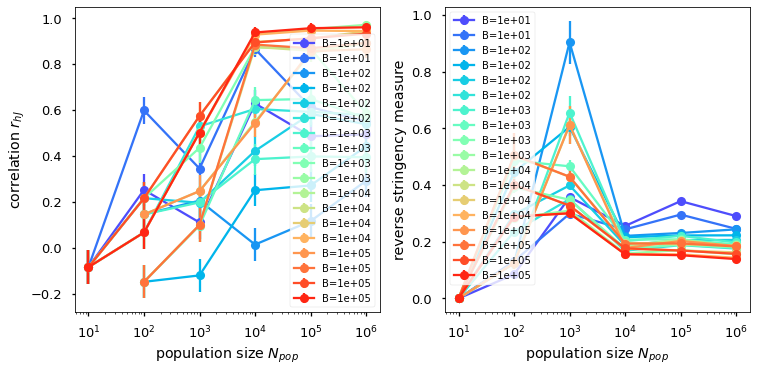

linear correlation between r_hJ and reverse stringency:  -0.20142022285501007  with p value:  0.034853396149925574
rank correlation between r_hJ and reverse stringency:  -0.2499769038666727  with p value:  0.008443931603509482


In [23]:
# load analysis results and make plots for B, N_pop

# set legend font size
plt.rc('legend', fontsize=10)

simu_name = '2021Apr07'

result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
                    'InfluenzaFitnessInference')
result_directory = os.path.normpath(result_directory)
temp_folder = os.path.join(result_directory, 'results', 'simulations', simu_name + '_temp')


analysis_filename = 'analysis_2021May04.data'

analysis_filepath = os.path.join(temp_folder, analysis_filename)
with open(analysis_filepath, 'rb') as f:
    ana_dict = pickle.load(f)
simu_info_filepath = ana_dict['simu_info_filepath']
with open(simu_info_filepath, 'rb') as f:
    simu_dict = pickle.load(f)
    
summary_stats_all = ana_dict['summary_stats_all']
ana_param_dict = ana_dict['ana_param_dict']
varied_ana_params = ana_dict['varied_ana_params']
varied_simu_params = simu_dict['varied_simu_params']
ana_list = ana_dict['ana_list']
run_list = simu_dict['run_list']
exp_dict = simu_dict['exp_dict']
exp_ana_dict = ana_dict['exp_ana_dict']
print(exp_dict)
print(exp_ana_dict)

### plots
file_ext_length = len('.data')
plot_file_path = analysis_filepath[:-file_ext_length] + '_plot'

##################################################################
## plot for varying N_pop
#################################################################
# plot against the varied analysis param
this_plot_filepath = plot_file_path + 'N_pop' + '.png'

fig, ((ax1,ax2)) = plt.subplots(1, 2, constrained_layout=True)

##################################
# plot correlation r_hJ as function of N_pop

param_name = 'r_hJ'
r_hJ = summary_stats_all[param_name]
SE_r_hJ = summary_stats_all['SE_' + param_name]

r_hJ_arr = np.reshape(np.array(r_hJ), (len(ana_list), len(run_list)))
SE_r_hJ_arr = np.reshape(np.array(SE_r_hJ), (len(ana_list), len(run_list)))

# num_colors = len(run_list)
# cm = plt.get_cmap('rainbow')
# colorlist=list(cm(1.*i/num_colors) for i in range(num_colors))

# test_param_list = exp_ana_dict['B']
# for runnum in run_list:
#     # plot linear correlation against varied simu param for a specific set
#     # of analysis params
#     ax1.errorbar(test_param_list, r_hJ_arr[:, runnum], SE_r_hJ_arr[:, runnum], 
#                  marker='o',linestyle='-',zorder=1, color=colorlist[runnum], label='N_pop=%.e' % exp_dict['N_pop'][runnum])
# ax1.legend(bbox_to_anchor=(0.5, -0.2))
# ax1.set_xlabel('sampling size B')
# ax1.set_ylabel('linear correlation between h_i + h_j + J_ij')
# ax1.set_xscale('log')
# ax1.set_aspect(1/ax1.get_data_ratio())

# plot against the varied simu param

num_colors = len(ana_list)
cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/num_colors) for i in range(num_colors))

test_param_list = exp_dict['N_pop']
for ananum in ana_list[2:]:
    # plot linear correlation against varied simu param for a specific set
    # of analysis params
    ax1.errorbar(test_param_list, r_hJ_arr[ananum, :], SE_r_hJ_arr[ananum, :], 
                 marker='o',linestyle='-',zorder=1, color=colorlist[ananum], label='B=%.e' % exp_ana_dict['B'][ananum])
# ax1.legend(bbox_to_anchor=(0.5, -0.2))
ax1.legend()
ax1.set_xlabel('population size $N_{pop}$')
ax1.set_ylabel('correlation $r_{hJ}$')
ax1.set_xscale('log')
ax1.set_aspect(1/ax1.get_data_ratio())

############################################
# plot stringency as function of N_pop

param_name = 'mean_string'
param = summary_stats_all[param_name]
# SE_r_hJ = summary_stats_all['SE_' + param_name]
SE_param = summary_stats_all['SE_string']

param_arr = np.reshape(np.array(param), (len(ana_list), len(run_list)))
SE_param_arr = np.reshape(np.array(SE_param), (len(ana_list), len(run_list)))

# num_colors = len(run_list)
# cm = plt.get_cmap('rainbow')
# colorlist=list(cm(1.*i/num_colors) for i in range(num_colors))
# test_param_list = exp_ana_dict['B']
# for runnum in run_list:
#     # plot linear correlation against varied simu param for a specific set
#     # of analysis params
#     ax1.errorbar(test_param_list, param_arr[:, runnum], SE_param_arr[:, runnum], 
#                  marker='o',linestyle='-',zorder=1, color=colorlist[runnum], label='N_pop=%.e' % exp_dict['N_pop'][runnum])
# ax1.legend(bbox_to_anchor=(0.5, -0.2))
# ax1.set_xlabel('sampling size B')
# ax1.set_ylabel('reverse stringency = <std(F_tot)/std(F_host)>')
# ax1.set_xscale('log')
# ax1.set_aspect(1/ax1.get_data_ratio())

# plot against the varied simu param

num_colors = len(ana_list)
cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/num_colors) for i in range(num_colors))
test_param_list = exp_dict['N_pop']
for ananum in ana_list[2:]:
    # plot linear correlation against varied simu param for a specific set
    # of analysis params
    ax2.errorbar(test_param_list, param_arr[ananum, :], SE_param_arr[ananum, :], 
                 marker='o',linestyle='-',zorder=1, color=colorlist[ananum], label='B=%.e' % exp_ana_dict['B'][ananum])
ax2.legend()
# ax2.legend(bbox_to_anchor=(0.5, -0.2))
ax2.set_xlabel('population size $N_{pop}$')
ax2.set_ylabel('reverse stringency measure')
ax2.set_xscale('log')
ax2.set_aspect(1/ax2.get_data_ratio())

plt.savefig(this_plot_filepath, bbox_inches='tight')
plt.show()
plt.close()

# calculate correlation between stringency measure and inference performance measure r_hJ

mean_string_list = summary_stats_all['mean_string']
r_hJ_list = summary_stats_all['r_hJ']
tup_r_string = zip(r_hJ_list, mean_string_list)
r_string_nonan = []
for tup in tup_r_string:
    if not (np.isnan(tup[0]) or np.isnan(tup[1])):
        r_string_nonan.append(list(tup))
r_string_nonan = np.array(r_string_nonan)
r_hJ_nonan = np.transpose(r_string_nonan)[0]
mean_string_nonan = np.transpose(r_string_nonan)[1]
        
r_r_string, pval = scipy.stats.pearsonr(r_hJ_nonan, mean_string_nonan)
rSpear_r_string, pvalSpear = scipy.stats.spearmanr(r_hJ_nonan, mean_string_nonan)

print('linear correlation between r_hJ and reverse stringency: ', r_r_string, ' with p value: ', pval)
print('rank correlation between r_hJ and reverse stringency: ', rSpear_r_string, ' with p value: ', pvalSpear)

In [ ]:
# for one example analysis:
# plot distibutions of intrinsic, host and total fitness over time for stringency analysis
# and inference performance plot h vs h, J vs J, h+h+J vs h+h+J
# and strain succession plot with two panels

# load analysis and simu info

simu_name = '2021Apr07'

result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
                    'InfluenzaFitnessInference')
result_directory = os.path.normpath(result_directory)
temp_folder = os.path.join(result_directory, 'results', 'simulations', simu_name + '_temp')

# analysis_filename = 'analysis_2021May04.data'
analysis_filename = 'analysis_2021Apr14.data'
analysis_filepath = os.path.join(temp_folder, analysis_filename)
with open(analysis_filepath, 'rb') as f:
    ana_dict = pickle.load(f)
simu_info_filepath = ana_dict['simu_info_filepath']
with open(simu_info_filepath, 'rb') as f:
    simu_dict = pickle.load(f)

# # check what is in ana_dict  
# for key, val in ana_dict.items():
#     print(key)
    
ana_names = ana_dict['ana_names'] 

# look at one specific analysis

## for analysis from Apr 7 with Npop=10^5, B=10^3
single_ana_num = 16 
## for analysis from Apr 16 with l=100, B=10^4, inf_end=200
# single_ana_num = 95 

ana_name = ana_names[single_ana_num]
print(ana_name)
# print(ana_dict['exp_ana_dict']['inf_end'][2])
# print(ana_dict['exp_ana_dict']['B'][2])
# print(simu_dict['exp_dict']['N_site'][4])

ana_file_path = os.path.join(temp_folder, ana_name + '.data')
with open(ana_file_path, 'rb') as f:
    analysis_results = pickle.load(f)

# for key, val in analysis_results.items():
#     print(key)
fint_yearly = analysis_results['fint_yearly']
minus_fhost_yearly = analysis_results['minus_fhost_yearly']
ftot_yearly = analysis_results['ftot_yearly']
summary_stats = analysis_results['summary_stats']


######################################
# plot the fitness distributions 
this_plot_filename =  ana_name + '_plot_fitness_dists' +  '.png'
this_fitness_plot_filepath = os.path.join(temp_folder, this_plot_filename)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, constrained_layout=True)

# F_int
for y in range(len(fint_yearly[1:])):
    ax1.plot([y]*len(fint_yearly[y]), fint_yearly[y] - np.mean(fint_yearly[y]), '.', markersize=3, color='black')
ax1.set_xlabel('time step $t$')
ax1.set_ylabel('$F_{int} - <F_{int}>$')
ax1.set_ylim([-15, 15])
ax1.set_aspect(1.5/ax1.get_data_ratio())
# text = 'mean(std) = %.2f' % summary_stats['f_int_std']
# ax1.text(0.95, 0.95, text, horizontalalignment='right', 
#          verticalalignment='top', transform=ax1.transAxes)

# -F_host
for y in range(len(minus_fhost_yearly[1:])):
    ax2.plot([y]*len(minus_fhost_yearly[y]), minus_fhost_yearly[y] - np.mean(minus_fhost_yearly[y]), '.', markersize=3, color='black')
ax2.set_xlabel('time step $t$')
ax2.set_ylabel('$-F_{host} - <-F_{host}>$')
ax2.set_ylim([-15, 15])
ax2.set_aspect(1.5/ax2.get_data_ratio())
# text = 'mean(std) = %.2f' % summary_stats['f_host_std']
# ax2.text(0.95, 0.95, text, horizontalalignment='right', 
#          verticalalignment='top', transform=ax2.transAxes)

# F_tot
for y in range(len(ftot_yearly[1:])):
    ax3.plot([y]*len(ftot_yearly[y]), ftot_yearly[y] - np.mean(ftot_yearly[y]), '.', markersize=3, color='black')
ax3.set_xlabel('time step $t$')
ax3.set_ylabel('$F_{total} - <F_{total}>$')
ax3.set_ylim([-15, 15])
ax3.set_aspect(1.5/ax3.get_data_ratio())
# text = 'mean(std) = %.2f' % summary_stats['f_tot_std']
# ax3.text(0.95, 0.95, text, horizontalalignment='right', 
#          verticalalignment='top', transform=ax3.transAxes)

plt.savefig(this_fitness_plot_filepath, bbox_inches='tight')
plt.show()
plt.close()

####################################################
# plot of inference performance h vs h, J vs J, h+h+J vs h+h+J 

this_plot_filename =  ana_name + '_plot_inf_performance' +  '.png'
this_inf_performance_plot_filepath = os.path.join(temp_folder, this_plot_filename)

# print([key for key, val in analysis_results.items()])
# print([key for key, val in summary_stats.items()])

simu_param_dict = simu_dict['simu_param_dict']
N_site = simu_param_dict['N_site']
N_state = simu_param_dict['N_state']
h_0 = simu_param_dict['h_0']
J_0 = simu_param_dict['J_0']
hJ_coeffs = simu_param_dict['hJ_coeffs']
if hJ_coeffs=='constant':
    h_model, J_model = simu.fitness_coeff_constant(N_site, N_state, h_0, J_0)
elif hJ_coeffs=='p24':
    h_model, J_model = simu.fitness_coeff_p24(N_site, N_state)
M = analysis_results['M']
M_std = analysis_results['M_std']
h_model_list, J_model_list, hJ_model_list = ana.hJ_model_lists(h_model, J_model)
h_inf_list, J_inf_list, hJ_inf_list = ana.hJ_inf_lists(M, N_site)
std_h_inf_list, std_J_inf_list, std_hJ_inf_list = ana.hJ_inf_std_lists(M_std, N_site)

## comparison of inferred and model coefficients in one figure with 3 panels:
fig, ((ax1,ax2,ax3)) = plt.subplots(1, 3, constrained_layout=True)
# plt.rc('text', usetex=False)
# subplot for h comparison
x=np.linspace(-10,2,num=2)
ax1.errorbar(h_model_list, h_inf_list, std_h_inf_list, marker='o', linestyle='none', zorder=1)
ax1.plot(x,x,'-',color='black')
ax1.set(xlabel='simulated h')
ax1.set(ylabel='inferred h')
ax1.set_aspect(1/ax1.get_data_ratio())
text = '$r_h$ = %.2f, p = %.1e' % (summary_stats['r_h'], summary_stats['pr_h'])
ax1.text(0.05, 0.95, text, horizontalalignment='left', 
         verticalalignment='top', transform=ax1.transAxes)

# subplot for J comparison
x=np.linspace(-2,3,num=2)
ax2.errorbar(J_model_list, J_inf_list, std_J_inf_list, marker='o', linestyle='none', zorder=1)
ax2.plot(x,x,'-',color='black')
ax2.set(xlabel='simulated $J$')
ax2.set(ylabel='inferred $J$')
ax2.set_aspect(1/ax2.get_data_ratio())
text = '$r_J$ = %.2f, p = %.1e' % (summary_stats['r_J'], summary_stats['pr_J'])
ax2.text(0.05, 0.95, text, horizontalalignment='left',
        verticalalignment='top', transform=ax2.transAxes)

# subplot for hi+hj+Jij comparison
x=np.linspace(-15,5,num=2)
ax3.errorbar(hJ_model_list, hJ_inf_list, std_hJ_inf_list, marker='o', linestyle='none', zorder=1)
ax3.plot(x,x,'-',color='black')
ax3.set(xlabel='simulated $h_k + h_l + J_{kl}$')
ax3.set(ylabel='inferred $h_k + h_l + J_{kl}$')
ax3.set_aspect(1/ax3.get_data_ratio())
text = '$r_{hJ}$ = %.2f, p = %.1e' % (summary_stats['r_hJ'], summary_stats['pr_hJ'])
ax3.text(0.05, 0.95, text, horizontalalignment='left',
        verticalalignment='top', transform=ax3.transAxes)

plt.savefig(this_inf_performance_plot_filepath, bbox_inches='tight')
plt.show()
plt.close()

print('r_h: ' , summary_stats['r_h'], 'pr_h: ', summary_stats['pr_h'])
print('r_J: ', summary_stats['r_J'], 'pr_J: ', summary_stats['pr_J'])
print('r_hJ: ', summary_stats['r_hJ'], 'pr_hJ: ', summary_stats['pr_hJ'])

#########################
# strain succession plot

strain_yearly = analysis_results['strain_sample_yearly']
strain_frequency_yearly = analysis_results['strain_sample_frequency_yearly']
year_list = [y for y in range(len(strain_yearly))]

# collect all strains in time ordered list
strain_All_timeOrdered = []
# strain_All_freq_list = []
for y in range(len(strain_yearly)): # for each time point
    for sti in range(len(strain_yearly[y])): # for each strain at this time
        if strain_yearly[y][sti].tolist() not in strain_All_timeOrdered:
            strain_All_timeOrdered.append(strain_yearly[y][sti].tolist())
#             strain_All_freq_list.append(strain_frequency_yearly[y][sti]) # unnormalized (adding yearly freq)
#         else:
#             strain_All_freq_list[strain_All_timeOrdered.index(strain_yearly[y][sti].tolist())] += strain_frequency_yearly[y][sti]
# merge_list=list(zip(strain_All_freq_list, strain_All_timeOrdered))
# merge_list.sort(reverse=True) # sort coarse strain list according to count
# strain_All_freq_list = strain_All_freq_list/len(strain_yearly) # normalized by number of time points
# strain_All_timeOrdered=[x for y,x in merge_list]

# assign strain label to each strain in each year
strain_All_freq_yearly=[[0 for i in range(len(strain_All_timeOrdered))] for y in range(len(strain_yearly))] # frequency of all ever observed strains in each year
strain_index_yearly=[[0 for sti in range(len(strain_yearly[y]))] for y in range(len(strain_yearly))] # strain labels for strains that are observed in each year
for y in range(len(strain_yearly)):
    for sti in range(len(strain_yearly[y])):
        label=strain_All_timeOrdered.index(strain_yearly[y][sti].tolist()) # strain label
        strain_All_freq_yearly[y][label]=strain_frequency_yearly[y][sti] # strain frequency update
        strain_index_yearly[y][sti]=label # save strain label

this_plot_filename =  ana_name + '_plot_strain_succession' +  '.png'
this_plot_filepath = os.path.join(temp_folder, this_plot_filename)

cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/(len(strain_All_timeOrdered))) for i in range(len(strain_All_timeOrdered)))
#colorlist=list(cm(1.*i/100) for i in range(100))

strain_frequency_yearly_transpose=list(map(list, zip(*strain_All_freq_yearly)))
fig, ((ax1, ax2)) = plt.subplots(1, 2, constrained_layout=True)

for sti in range(len(strain_All_timeOrdered)):
#for sti in range(100):
    ax1.plot(year_list,strain_frequency_yearly_transpose[sti],color=colorlist[sti])
ax1.set_xlabel('simulated season')
ax1.set_ylabel('strain frequency')
ax1.set_aspect(0.7/ax1.get_data_ratio())
        
for y in range(len(strain_yearly)):
    for sti in range(len(strain_index_yearly[y])-1,-1,-1): # reverse loop through list to have dominant strains on top
        ax2.plot(y+year_list[0],strain_index_yearly[y][sti],'.',color='blue')
    ax2.plot(y+year_list[0],strain_index_yearly[y][0],'.',color='red')
ax2.set_xlabel('simulated season')
ax2.set_ylabel('strain label')
ax2.set_aspect(0.7/ax2.get_data_ratio())

plt.savefig(this_plot_filepath,  bbox_inches='tight')
plt.show()
plt.close()

######################
# precision-recall curve and ROC curve with calculated AUCs


this_plot_filename =  ana_name + '_classification_performance' +  '.png'
this_plot_filepath = os.path.join(temp_folder, this_plot_filename)

# threshold for classifying mut. pair as deleterious, if h+h+J<threshold
hJ_threshold = -10
# real classification of each pair
hJ_deleterious = np.int_(hJ_model_list<hJ_threshold)
# class imbalance: number in deleterious class/total number of pairs
positive_rate = sum(hJ_deleterious)/len(hJ_deleterious)
print('class imbalance: ', positive_rate)
# classification of each pair with classifier
hJ_del_pred = np.int_(hJ_inf_list<hJ_threshold)


fig, ((ax1, ax2)) = plt.subplots(1, 2, constrained_layout=True)

# precision-recall curve
precision, recall, thresholds = precision_recall_curve(hJ_deleterious, hJ_del_pred)

AUC_prec_recall = auc(recall, precision)
print('precision-recall AUC: ', AUC)

ax1.plot([0, 1], [positive_rate, positive_rate], linestyle = '--', label='no skill')
ax1.plot(recall, precision, marker='.', label='precision-recall AUC = %.2f' % AUC_prec_recall)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend()
ax1.set_aspect(1/ax1.get_data_ratio())

# ROC

AUC_ROC = roc_auc_score(hJ_deleterious, hJ_del_pred)
print('ROC AUC: ', AUC)

fpr, tpr, _ = roc_curve(hJ_deleterious, hJ_del_pred)

ax2.plot([0, 1], [0, 1], linestyle='--', label='no skill')
ax2.plot(fpr, tpr, marker='.', label='ROC AUC = %.2f' % AUC_ROC)
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.legend()
ax2.set_aspect(1/ax2.get_data_ratio())

plt.savefig(this_plot_filepath,  bbox_inches='tight')
plt.show()
plt.close()

plt.show()
plt.close()

In [ ]:
## calculate log(x/x')

# print(ana_names)
# print(ana_dict['exp_ana_dict'])

# look at one specific analysis

# ## for analysis from Apr 7 with Npop=10^5, B=10^3
# single_ana_num = 16 
# ## for analysis from Apr 7 with Npop=10^5, B=10^5
# single_ana_num = 28 
## for analysis from Apr 7 with Npop=10^5, B=10
single_ana_num = 4 

ana_name = ana_names[single_ana_num]
# print(ana_name)
# print(ana_dict['exp_ana_dict']['inf_end'][2])
# print(ana_dict['exp_ana_dict']['B'][2])
# print(simu_dict['exp_dict']['N_site'][4])

ana_file_path = os.path.join(temp_folder, ana_name + '.data')
with open(ana_file_path, 'rb') as f:
    analysis_results = pickle.load(f)
    
fint_yearly = analysis_results['fint_yearly']
minus_fhost_yearly = analysis_results['minus_fhost_yearly']
ftot_yearly = analysis_results['ftot_yearly']

# print([key for key, val in analysis_results.items()])
# print([key for key, val in simu_dict['simu_param_dict'].items()])

def xPrime_freq(strain_samp_yearly,strain_samp_freq_yearly, infer_start, infer_end,mu0,mu1):
    """ strain frequencies after mutation calculated from list of strain frequencies and mutation prob.s, for symmetric mut. rates
    strain_samp_yearly: sampled strains for each generation
    strain_samp_freq_yearly: frequencies for each generation for each strain
    infer_start: starting generation for inference
    infer_end: last generation for inference
    mu0: probability to keep current state at a site
    mu1: probability to mutate to a different state at a site
    returns frequency list of strains after mutation
    """
    N_site=len(strain_samp_yearly[0][0])
    strain_samp_XPrime_yearly=[[0]*len(strain_samp_yearly[y+1]) for y in range(infer_start,infer_end-1)]
    for y in range(infer_start,infer_end-1): # for each previous gen.
        for i in range(len(strain_samp_yearly[y+1])): # for each strain in next gen.
            XPrime=0
            seq1=strain_samp_yearly[y+1][i]
            for j in range(len(strain_samp_yearly[y])): # for each strain in prev. gen.
                seq2=strain_samp_yearly[y][j]
                mut_dist=sum([int(seq2[k]!=seq1[k]) for k in range(N_site)])
                XPrime+=mu0**(N_site-mut_dist)*mu1**mut_dist*strain_samp_freq_yearly[y][j]
            strain_samp_XPrime_yearly[y-infer_start][i]=XPrime
    strain_samp_mut_freq_yearly=[[strain_XP[i]/sum(strain_XP) for i in range(len(strain_XP))] for strain_XP in strain_samp_XPrime_yearly]
    return strain_samp_mut_freq_yearly

# print(len(analysis_results['strain_sample_frequency_yearly']))
strain_yearly = analysis_results['strain_sample_yearly']
strain_frequency_yearly = analysis_results['strain_sample_frequency_yearly']
xPrime_yearly = xPrime_freq(strain_yearly, strain_frequency_yearly, 0, len(strain_yearly), 1-10**(-4), 10**(-4))

xNext_yearly = strain_frequency_yearly[1:]
strainNext_yearly = strain_yearly[1:]

log_ratio_yearly=[[0]*len(xNext_yearly[y]) for y in range(len(xNext_yearly))]

for y in range(len(xNext_yearly)):
    for i in range(len(xNext_yearly[y])):
        log_ratio_yearly[y][i]=np.log(xNext_yearly[y][i]/xPrime_yearly[y][i])

fig = plt.figure()
for y in range(len(log_ratio_yearly)):
    plt.plot([y]*len(log_ratio_yearly[y]), log_ratio_yearly[y] - np.mean(log_ratio_yearly[y]), '.', markersize=3, color='black')
plt.xlabel('time step $t$')
plt.ylabel('log(x(t+1)/x(t)) - <log(x(t+1)/x(t)>')

mean_string1 = np.mean([(np.std(ftot)/np.std(mfhost)) for mfhost, ftot in zip(minus_fhost_yearly, log_ratio_yearly)])
mean_string2 = np.mean([(np.std(ftot)/np.std(mfhost)) for mfhost, ftot in zip(minus_fhost_yearly, ftot_yearly)])

print(mean_string1, mean_string2)

mean_stdlogratio = np.mean([np.std(ftot) for ftot in log_ratio_yearly])
mean_stdftot = np.mean([np.std(ftot) for ftot in ftot_yearly])

print(mean_stdlogratio, mean_stdftot)

In [ ]:
#######################################################################
# old analysis

In [ ]:
print(ana_dict['ana_param_dict'])
print(simu_dict['simu_param_dict'])
print(simu_dict['exp_dict'])
print(ana_dict['exp_ana_dict'])

In [ ]:
# print(ana_names)
print(ana_dict['exp_ana_dict']['inf_end'][15])
print(ana_dict['exp_ana_dict']['B'][15])
print(simu_dict['exp_dict']['N_site'][5])

In [ ]:
# # load data from file again

# result_directory = os.path.normpath(result_directory)
# ana_file = os.path.join(result_directory, 'results', 'simulations', 'ana' + simu_name + '.data') 

# with open(ana_file, 'rb') as f:
#     ana_dict = pickle.load(f)
    
# summary_stats_all = ana_dict['summary_stats_all']
# inf_dict = ana_dict['inf_dict']
# exp_dict = inf_dict['exp_dict']


# ind_0 = 0
# r_hJ = summary_stats_all['r_hJ'][ind_0:]
# SE_r_hJ = summary_stats_all['SE_r_hJ'][ind_0:]
# N_pop_list = exp_dict['N_pop']

# # plot r_hJ +- SE_r_hJ
# fig = plt.figure()
# plt.errorbar(N_pop_list, r_hJ, SE_r_hJ, marker='o',linestyle='none',zorder=1)
# plt.xscale('log')
# plt.show()
# plt.close()

In [ ]:
# # sampling and inference parameters
# exp_dict = {'N_pop' : [10, 100, 10**3, 10**4, 10**5, 10**6]}

# result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
#                     'InfluenzaFitnessInference')
# simu_name = '2021Apr07'
# single_simu_filename =\
# 'running_N_pop_1e+04N_site_20N_state_2mu_1e-04sigma_h_1D0_5h_0_-7J_0_0seed_123456N_simu_2e+02.data'
# exp_idx = 3

# # number of sequences sampled from surviving strains
# B = 10**3 
# # RNG seed for sampling
# seed = 20390 
# # generations to start and end inference
# inf_start = 100 
# inf_end = 200
# # regularization coefficients for the three types of inferred parameters
# # 0 means no regularization, 1 means unit variance
# lambda_h = 0
# lambda_J = 1
# lambda_f = 0

# inf_dict ={'simu_name': simu_name, 
#                'exp_dict': exp_dict, 
#                'seed': seed, 
#                'B': B, 
#                'inf_start': inf_start, 
#                'inf_end': inf_end, 
#                'lambda_h': lambda_h, 
#                'lambda_J': lambda_J, 
#                'lambda_f': lambda_f}

# # # run full analysis for a single simulation:

# # summary_stats = ana.single_simu_analysis(single_simu_filename, simu_name, exp_idx,
# #                                          seed, B, inf_start, inf_end, lambda_h, lambda_J, lambda_f,
# #                                          result_directory='C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/'
# #                                     'NewApproachFromMarch2021/InfluenzaFitnessInference')

In [ ]:
# strain_yearly, strain_frequency_yearly, traj2 = ana.load_simu_data(single_simu_filename, simu_name, exp_idx)

# traj2.v_idx = 2
# # traj2.f_add_result('summary_stats', summary_stats,
# #                       comment='summary statistics')
# print(traj2.N_pop)

In [ ]:
# strain_yearly, strain_frequency_yearly, traj =\
#         ana.load_simu_data(single_simu_filename, simu_name, exp_idx, result_directory=result_directory)

# # model fitness landscape
# if traj.hJ_coeffs=='constant':
#     h_model, J_model = simu.fitness_coeff_constant(traj.N_site, traj.N_state, traj.h_0, traj.J_0)
# elif traj.hJ_coeffs=='p24':
#     h_model, J_model = simu.fitness_coeff_p24(traj.N_site, traj.N_state)

In [ ]:
# # strain_yearly = [strains.tolist() for strains in strain_yearly]
# print(strain_yearly[0])

In [ ]:
# # take random samples from each inference generation
# strain_sample_yearly, strain_sample_count_yearly, strain_sample_frequency_yearly=\
#     ana.sample_seqs(strain_yearly, strain_frequency_yearly, seed_sample, B, inf_end)

# # calculate -F_host for each time step between inf_start and inf_end
# minus_fhost_yearly = [-simu.fitness_host_list(strain_sample_yearly[t], strain_sample_yearly[:t], 
#                                               strain_sample_frequency_yearly[:t], traj.sigma_h, traj.D0)
#                     for t in range(inf_start, inf_end)]

# # calculate F_int for each time step between inf_start and inf_end
# fint_yearly = [simu.fitness_int_list(strain_sample_yearly[t], traj.N_state, h_model, J_model)
#                     for t in range(inf_start, inf_end)]

# # F_tot= F_int + F_host for each time step between inf_start and inf_end
# ftot_yearly = [[fint_yearly[t][i] - minus_fhost_yearly[t][i] for i in range(len(minus_fhost_yearly[t]))] 
#                for t in range(len(minus_fhost_yearly))]

In [ ]:
# # process data for inference (calculation of feature matrix X and output matrix Y)

# # calculation of features matrix X
# X = ana.inference_features_Ising(strain_sample_yearly[inf_start:inf_end])

# # calculation of response vector Y
# Y = ana.inference_response_FhostPrediction(minus_fhost_yearly)

# # inference (parameter vector M and standard error M_std of inferred params):
# M, M_std = ana.infer_ridge(X, Y, lambda_h, lambda_J, lambda_f, inf_start, inf_end)

In [ ]:
# mean std of fitnesses:

f_host_std = np.mean([np.std(fs) for fs in minus_fhost_yearly])
f_int_std = np.mean([np.std(fs) for fs in fint_yearly])
f_tot_std = np.mean([np.std(fs) for fs in ftot_yearly])
stringency = np.mean([(np.std(ftot)/np.std(mfhost)) for mfhost, ftot in zip(minus_fhost_yearly, ftot_yearly)])
SE_string = np.std([(np.std(ftot)/np.std(mfhost)) for mfhost, ftot in zip(minus_fhost_yearly, ftot_yearly)])/len(ftot_yearly)
print('mean std of F_host: ', f_host_std)
print('mean std of F_int: ', f_int_std)
print('mean std of F_tot: ', f_tot_std)
print('selection stringency: ', stringency, ' standard error: ', SE_string)

In [ ]:
# compare model fitness coeffs against inferred coeffs

# model coefficients
h_model_list, J_model_list, hJ_model_list = ana.hJ_model_lists(h_model, J_model)
# inferred coefficients
h_inf_list, J_inf_list, hJ_inf_list = ana.hJ_inf_lists(M, traj.N_site)
# std of inferred coefficients
std_h_inf_list, std_J_inf_list, std_hJ_inf_list = ana.hJ_inf_std_lists(M_std, traj.N_site)

r_h, pr_h=scipy.stats.pearsonr(h_model_list, h_inf_list) # pearson correlation
print('linear correlation for h: rho=',r_h,', p=',pr_h)
r_J, pr_J=scipy.stats.pearsonr(J_model_list, J_inf_list) 
print('linear correlation for J: rho=',r_J,', p=',pr_J)
r_hJ, pr_hJ=scipy.stats.pearsonr(hJ_model_list, hJ_inf_list) 
print('linear correlation for hi+hj+Jij: rho=',r_hJ,', p=',pr_hJ)

rho_h, prho_h=scipy.stats.spearmanr(h_model_list,h_inf_list) # spearman rank correlation
print('Spearman rank correlation for h: rho=',rho_h,', p=',prho_h)
rho_J, prho_J=scipy.stats.spearmanr(J_model_list,J_inf_list) # spearman rank correlation
print('Spearman rank correlation for J: rho=',rho_J,', p=',prho_J)
rho_hJ, prho_hJ=scipy.stats.spearmanr(hJ_model_list,hJ_inf_list) # spearman rank correlation
print('Spearman rank correlation for hi+hj+Jij: rho=',rho_hJ,', p=',prho_hJ)

In [ ]:
N_site = traj.N_site

h_epi_model,J_epi_model,hJ_epi_model=hJ_redlist_fromlist(h_model, J_model, N_site, 0) # model params
h_epi_inf,J_epi_inf,hJ_epi_inf,f_inf=coeffs_inf_reduced(M,inf_start,inf_end,N_site,0) # inferred params
h_epi_std,J_epi_std,hJ_epi_std,f_std=coeffs_std_reduced(M_std,inf_start,inf_end,N_site,0)

## comparison of inferred and model coefficients in one figure with 3 panels:
fig, ((ax1,ax2,ax3)) = plt.subplots(1, 3, constrained_layout=True)
# subplot for h comparison
x=np.linspace(-10,2,num=2)
fig=plt.figure()
ax1.errorbar(h_epi_model,h_epi_inf,h_epi_std,marker='o',linestyle='none',zorder=1)
ax1.plot(x,x,'-',color='black')
ax1.set(xlabel='model h')
ax1.set(ylabel='inferred h')
ax1.set_aspect(1/ax1.get_data_ratio())
# subplot for J comparison
x=np.linspace(-2,3,num=2)
fig=plt.figure()
ax2.errorbar(J_epi_model,J_epi_inf,J_epi_std,marker='o',linestyle='none',zorder=1)
#plt.plot(J_model[1327],M[num_h+1327],marker='o',linestyle='none',color='yellow',zorder=2)
#plt.plot(J_model[113],M[num_h+113],marker='o',linestyle='none',color='red',zorder=2)
ax2.plot(x,x,'-',color='black')
ax2.set(xlabel='model J')
ax2.set(ylabel='inferred J')
ax2.set_aspect(1/ax2.get_data_ratio())
# subplot for hi+hj+Jij comparison
x=np.linspace(-15,5,num=2)
fig=plt.figure()
ax3.errorbar(hJ_epi_model,hJ_epi_inf,hJ_epi_std,marker='o',linestyle='none',zorder=1)
ax3.plot(x,x,'-',color='black')
ax3.set(xlabel='model hi+hj+Jij')
ax3.set(ylabel='inferred hi+hj+Jij')
ax3.set_aspect(1/ax3.get_data_ratio())

# # plot for f(t):
# fig=plt.figure()
# plt.errorbar(np.arange(len(f_inf)),f_inf,f_std,marker='o',linestyle='none',zorder=1)
# plt.xlabel('inference generation')
# plt.ylabel('inferred f(t)')
# plt.show()
# plt.close()


rho, pval=scipy.stats.pearsonr(h_epi_model.flatten(),h_epi_inf) # spearman rank correlation
print('linear correlation for h: rho=',rho,', p=',pval)
rho, pval=scipy.stats.pearsonr(np.array(J_epi_model).flatten(),J_epi_inf) # spearman rank correlation
print('linear correlation for J: rho=',rho,', p=',pval)
rho, pval=scipy.stats.pearsonr(np.array(hJ_epi_model).flatten(),hJ_epi_inf) # spearman rank correlation
print('linear correlation for hi+hj+Jij: rho=',rho,', p=',pval)

print('\n')

rho, pval=scipy.stats.spearmanr(h_epi_model,h_epi_inf) # spearman rank correlation
print('Spearman rank correlation for h: rho=',rho,', p=',pval)
rho, pval=scipy.stats.spearmanr(np.array(J_epi_model).flatten(),J_epi_inf) # spearman rank correlation
print('Spearman rank correlation for J: rho=',rho,', p=',pval)
rho, pval=scipy.stats.spearmanr(np.array(hJ_epi_model).flatten(),hJ_epi_inf) # spearman rank correlation
print('Spearman rank correlation for hi+hj+Jij: rho=',rho,', p=',pval)

In [ ]:
# plot the data and fitnesses 
cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/(len(minus_fhost_yearly))) for i in range(len(minus_fhost_yearly)))

# -F_host
figure=plt.figure()
for t in range(len(minus_fhost_yearly)):
    plt.plot([t]*len(minus_fhost_yearly[t]), minus_fhost_yearly[t],'.',color=colorlist[t])
plt.xlabel('time step t')
plt.ylabel('-F_host(S,t)')
#plt.ylim([-10,60])
plt.show()
plt.close()

# F_int
figure=plt.figure()
for t in range(len(fint_yearly)):
    plt.plot([t]*len(fint_yearly[t]), fint_yearly[t],'.',color=colorlist[t])
plt.xlabel('time step t')
plt.ylabel('F_int(S,t)')
#plt.ylim([-10,60])
plt.show()
plt.close()

ftot_yearly = [[fint_yearly[t][i] - minus_fhost_yearly[t][i] for i in range(len(minus_fhost_yearly[t]))] 
               for t in range(len(minus_fhost_yearly))]
# F_tot
figure=plt.figure()
for t in range(len(fint_yearly)):
    plt.plot([t]*len(ftot_yearly[t]), ftot_yearly[t],'.',color=colorlist[t])
plt.xlabel('time step t')
plt.ylabel('F_int(S,t)')
#plt.ylim([-10,60])
plt.show()
plt.close()

# mean std of fitnesses:
f_host_std = np.mean([np.std(fs) for fs in minus_fhost_yearly])
f_int_std = np.mean([np.std(fs) for fs in fint_yearly])
f_tot_std = np.mean([np.std(fs) for fs in ftot_yearly])
print('mean std of F_host: ', f_host_std)
print('mean std of F_int: ', f_int_std)
print('mean std of F_tot: ', f_tot_std)